In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import scipy
import os
%matplotlib inline
sns.set_style("white")
sns.set(color_codes=True)
pd.set_option('display.float_format', lambda x:'%f'%x)
from IPython.display import display
pd.options.display.max_columns = None

PROJECT_ROOT_DIR = "."
FOLDER = "california_housing"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Initial Exploration

In [3]:
housing = pd.read_csv('data/california-housing/california-housing.csv')

In [4]:
housing.shape

(20640, 10)

In [7]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000,NEAR BAY
1,-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000,NEAR BAY
2,-122.240000,37.850000,52.000000,1467.000000,190.000000,496.000000,177.000000,7.257400,352100.000000,NEAR BAY
3,-122.250000,37.850000,52.000000,1274.000000,235.000000,558.000000,219.000000,5.643100,341300.000000,NEAR BAY
4,-122.250000,37.850000,52.000000,1627.000000,280.000000,565.000000,259.000000,3.846200,342200.000000,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a27038c18>,
      dtype=object)

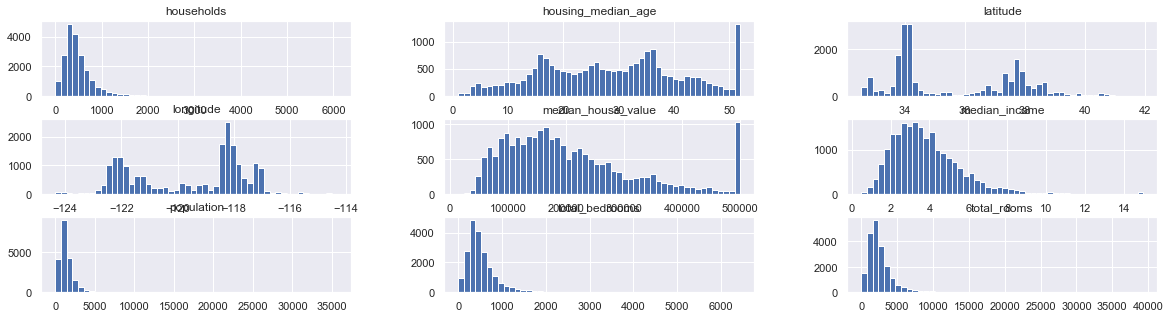

In [17]:
housing.hist(bins=50,figsize=(20,5))

In [18]:
housing.describe(include='O')

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


In [19]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

# Train Test Split

In [28]:
# Create strata from median_income
income_cat = pd.DataFrame()
income_cat = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in ss.split(housing, income_cat):
    train = housing.loc[train_index]
    test = housing.loc[test_index]

In [49]:
train.shape

(16512, 11)

In [50]:
test.shape

(4128, 11)

# EDA

In [51]:
housing = train.copy()

In [52]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.890000,37.290000,38.000000,1568.000000,351.000000,710.000000,339.000000,2.704200,286600.000000,<1H OCEAN,2
18632,-121.930000,37.050000,14.000000,679.000000,108.000000,306.000000,113.000000,6.421400,340600.000000,<1H OCEAN,5
14650,-117.200000,32.770000,31.000000,1952.000000,471.000000,936.000000,462.000000,2.862100,196900.000000,NEAR OCEAN,2
3230,-119.610000,36.310000,25.000000,1847.000000,371.000000,1460.000000,353.000000,1.883900,46300.000000,INLAND,2
3555,-118.590000,34.230000,17.000000,6592.000000,1525.000000,4459.000000,1463.000000,3.034700,254500.000000,<1H OCEAN,3


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Saving figure lat_long_plot


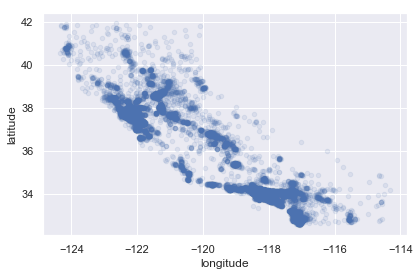

In [57]:
housing.plot(kind="scatter", x='longitude', y='latitude', alpha=0.1)
save_fig("lat_long_plot")

Saving figure housing_prices_scatterplot


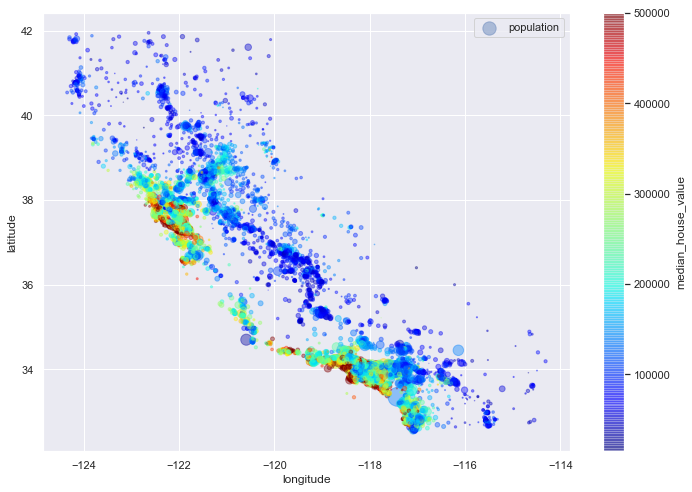

In [58]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

- radius of each circle represents the district’s population
- color represents the price which ranges from blue (low values) to red (high prices)

Saving figure california_housing_prices_plot


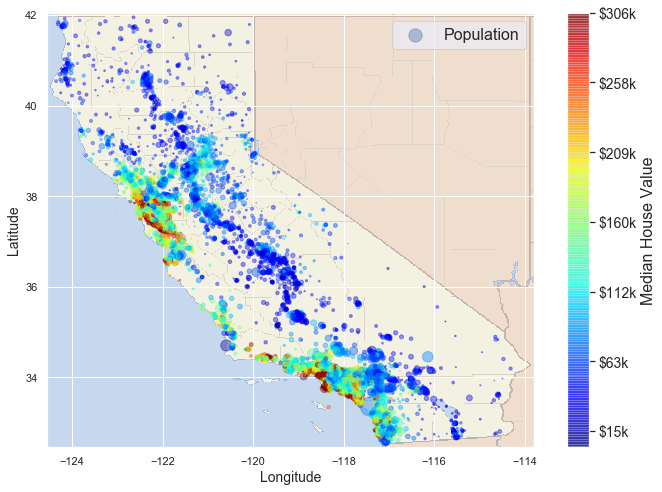

In [68]:
import matplotlib.image as mpimg
california_img=mpimg.imread(IMAGES_PATH + '/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

## Correlation Matrix

In [59]:
corr = housing.corr()

In [71]:
corr.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


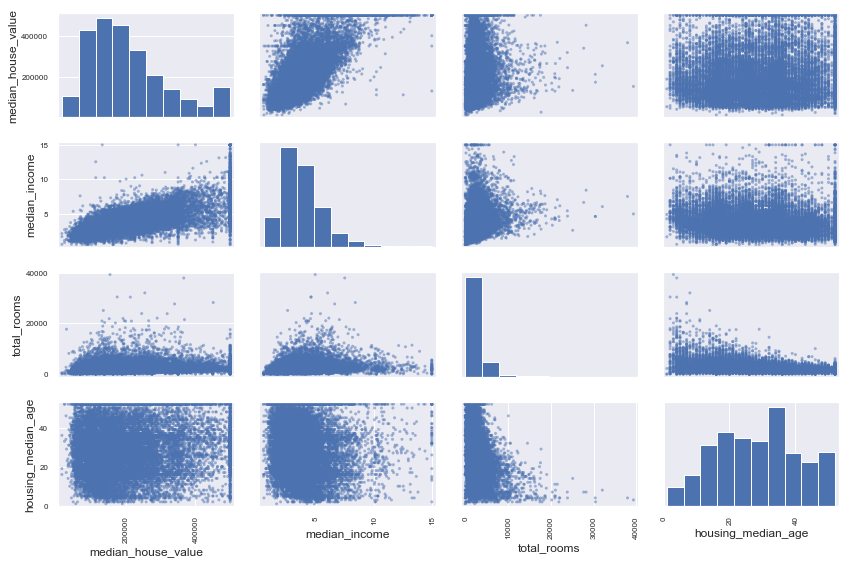

In [72]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Zooming in on the most promising feature that correlates the most to median_house_value

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


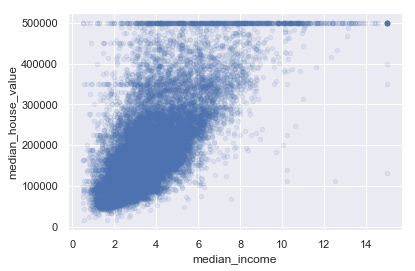

In [73]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at 500,000. But this plot reveals other less obvious straight lines: a horizontal line around 450,000, another around 350,000, perhaps one around 280,000, and a few more below that.

# Feature Engineering

Try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [74]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [75]:
corr = housing.corr()

In [76]:
corr.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


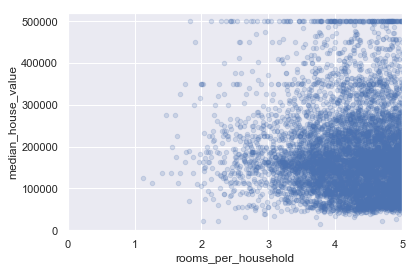

In [78]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

# Prepare

In [77]:
# don’t forget to save the median value, you will need it later to replace missing values in the test set
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [79]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
4629,-118.300000,34.070000,18.000000,3759.000000,433.000000,3296.000000,1462.000000,2.270800,175000.000000,<1H OCEAN,2,2.571135,nan,2.254446
6068,-117.860000,34.010000,16.000000,4632.000000,433.000000,3038.000000,727.000000,5.176200,264400.000000,<1H OCEAN,4,6.371389,nan,4.178817
17923,-121.970000,37.350000,30.000000,1955.000000,433.000000,999.000000,386.000000,4.632800,287100.000000,<1H OCEAN,4,5.064767,nan,2.588083
13656,-117.300000,34.050000,6.000000,2155.000000,433.000000,1039.000000,391.000000,1.667500,95800.000000,INLAND,2,5.511509,nan,2.657289
19252,-122.790000,38.480000,7.000000,6837.000000,433.000000,3468.000000,1405.000000,3.166200,191000.000000,<1H OCEAN,3,4.866192,nan,2.468327


## Imputer to fill in missing values

In [80]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [81]:
housing_num = housing.select_dtypes(include=[np.number])

In [82]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [83]:
imputer.statistics_ # median values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        1.79500000e+05,  5.23228423e+00,  2.03031374e-01,  2.81765270e+00])

In [85]:
housing_num.median().values # checking to see these are the same as actual median values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        1.79500000e+05,  5.23228423e+00,  2.03031374e-01,  2.81765270e+00])

In [88]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = list(housing.index.values))
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
4629,-118.300000,34.070000,18.000000,3759.000000,433.000000,3296.000000,1462.000000,2.270800,175000.000000,2.571135,0.203031,2.254446
6068,-117.860000,34.010000,16.000000,4632.000000,433.000000,3038.000000,727.000000,5.176200,264400.000000,6.371389,0.203031,4.178817
17923,-121.970000,37.350000,30.000000,1955.000000,433.000000,999.000000,386.000000,4.632800,287100.000000,5.064767,0.203031,2.588083
13656,-117.300000,34.050000,6.000000,2155.000000,433.000000,1039.000000,391.000000,1.667500,95800.000000,5.511509,0.203031,2.657289
19252,-122.790000,38.480000,7.000000,6837.000000,433.000000,3468.000000,1405.000000,3.166200,191000.000000,4.866192,0.203031,2.468327


Previously missing values have now been filled by the medians of each column

In [89]:
imputer.strategy

'median'

In [90]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
0,-121.890000,37.290000,38.000000,1568.000000,351.000000,710.000000,339.000000,2.704200,286600.000000,4.625369,0.223852,2.094395
1,-121.930000,37.050000,14.000000,679.000000,108.000000,306.000000,113.000000,6.421400,340600.000000,6.008850,0.159057,2.707965
2,-117.200000,32.770000,31.000000,1952.000000,471.000000,936.000000,462.000000,2.862100,196900.000000,4.225108,0.241291,2.025974
3,-119.610000,36.310000,25.000000,1847.000000,371.000000,1460.000000,353.000000,1.883900,46300.000000,5.232295,0.200866,4.135977
4,-118.590000,34.230000,17.000000,6592.000000,1525.000000,4459.000000,1463.000000,3.034700,254500.000000,4.505810,0.231341,3.047847


Earlier we left out the categorical attribute ocean_proximity because it is a text attribute so we cannot compute its median :)

In [91]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


With an OrdinalEncoder ML algorithms will assume that two nearby values are more similar than two distant values.

In [92]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for many categorical features. In these cases, we use a OneHotEncoder to create one binary attribute per category. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes.

In [93]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Note the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array,21 but if you really want to convert it to a (dense) NumPy array, just call the toarray() method: housing_cat_1hot.toarray()

In [96]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]